In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')

from tmm.get_jacobi_n_adjoint import get_jacobi_free_form
from film import TwoMaterialFilm, FreeFormFilm, BaseFilm
from design import DesignForFilm

from optimizer.adam_n import adam_optimize

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

inc_ang = 0.
wls = np.linspace(500, 2000, 500)

#  make target film
# np.random.seed(1)
# d = np.random.random(15)
# d *= 1000. / d.sum()

d = np.array([100, 100] * 5)
target_film = TwoMaterialFilm('1', '2', 'SiO2', d)
target_film.add_spec_param(inc_ang, wls)


In [ ]:
# thickness gd
np.random.seed(42)
init_layers = 100
d = np.random.random(init_layers) + 1.
d = d * 1000 / d.sum() # total gd = 1000 nm
rand_2m_gd_film = TwoMaterialFilm('1', '2', 'SiO2', d)
design = DesignForFilm(target_film, rand_2m_gd_film)

design.adam_gd(4000, record=True, show=True, alpha=0.1)


In [45]:

# free form gd
np.random.seed(42)
# n = np.random.random(1000) + 1. # in (1, 2)
n = np.random.random(1000)
free_film = FreeFormFilm(n, 1000., 'SiO2')

# free_film.add_spec_param(inc_ang, wls)
# plot_layer_thickness(free_film)

def gd_one_ang(target_film: BaseFilm, film: FreeFormFilm):
    target_film = copy.deepcopy(target_film)
    target_film.remove_all_spec_param()
    target_film.add_spec_param(0., wls)
    losses, films = adam_optimize(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=2, 
        batch_size_wl=100
    )
    return losses, films

def gd_two_angs(target_film: BaseFilm, film: FreeFormFilm):
    target_film = copy.deepcopy(target_film)
    
    target_film.remove_all_spec_param()
    target_film.add_spec_param(45., wls)
    # target_film.add_spec_param(0., wls)
    
    losses, films = adam_optimize(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=2, # note that this constraint is extra info
        batch_size_wl=500, 
        
    )
    return losses, films


losses, films = gd_two_angs(target_film, free_film)

working_film_save_dir = './films_double_specs'
with open(working_film_save_dir, 'wb') as  f:
    pickle.dump(films, f)

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


iter 0, loss 0.2769319543015847
iter 1, loss 0.2667894129542283
iter 2, loss 0.23906782397338366
iter 3, loss 0.20363665521307975
iter 4, loss 0.16844405869005932
iter 5, loss 0.14352050784526327
iter 6, loss 0.13915421035877223
iter 7, loss 0.14268396188517535
iter 8, loss 0.13622637777306565
iter 9, loss 0.12586670928412147
iter 10, loss 0.11454559006520194
iter 11, loss 0.10562007927150388
iter 12, loss 0.10031934851496167
iter 13, loss 0.0994765310906523
iter 14, loss 0.10129904233343068
iter 15, loss 0.10289988032764699
iter 16, loss 0.10234300356772902
iter 17, loss 0.09999986040027413
iter 18, loss 0.09705564579490396
iter 19, loss 0.09442326458508492
iter 20, loss 0.09264608500387111
iter 21, loss 0.09160983848409399
iter 22, loss 0.0908791059646005
iter 23, loss 0.090262514189208
iter 24, loss 0.08967364105207197
iter 25, loss 0.089103428458551
iter 26, loss 0.08857479173974163
iter 27, loss 0.08804995805233938
iter 28, loss 0.08752936477747629
iter 29, loss 0.0870754276964621

In [46]:
from analyze_utils.structure import diff_simple_film

with open(working_film_save_dir, 'rb') as f:
    films = pickle.load(f)
    
similarities = []

for film in films:
    similarities.append(diff_simple_film(target_film, film))
    


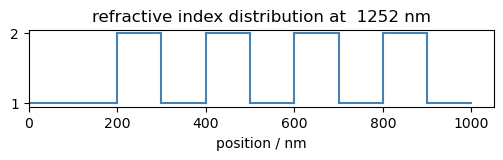

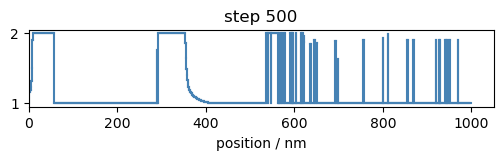

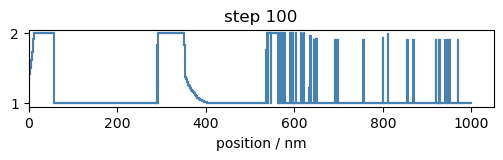

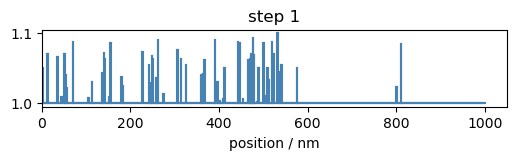

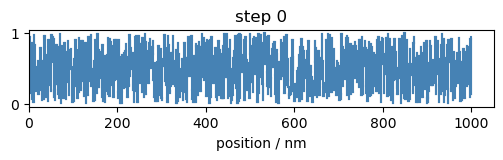

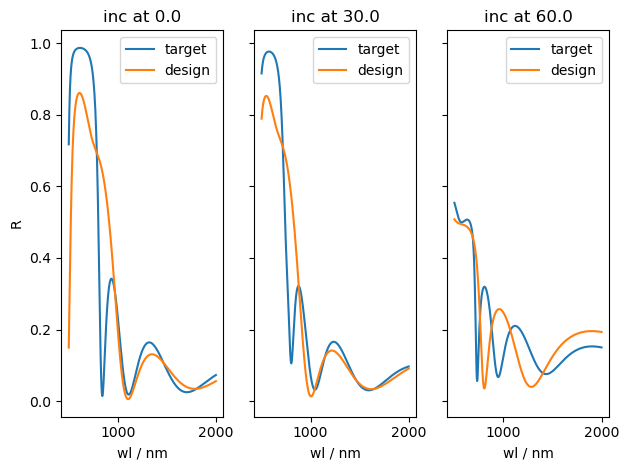

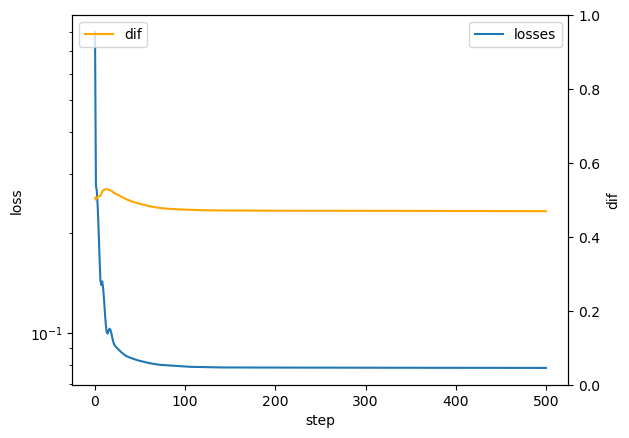

In [47]:

from analyze_utils.structure import plot_layer_thickness

plot_layer_thickness(target_film)
plot_i = list(range(2)) + [100, 500]
for i in plot_i[::-1]:
    ax, _ = plot_layer_thickness(films[i])
    ax.set_title(f'step {i}')


# plot specs# plot specs
spec_param_ls = [[0., wls], [30., wls], [60., wls]]
fig, axes = plt.subplots(
    1, 
    len(spec_param_ls), 
    sharey=True, 
)
axes = [axes] if isinstance(axes, plt.Axes) else axes # special case: 1 spec
axes[0].set_ylabel('R')
for ax, spec_arg in zip(axes, spec_param_ls):
    ax.plot(
        wls, 
        target_film.get_spec(*spec_arg).get_R(), 
        label='target'
    )
    ax.plot(
        wls, 
        free_film.get_spec(*spec_arg).get_R(), 
        label='design'
    )
    ax.set_title(f'inc at {spec_arg[0]}')
    ax.set_xlabel('wl / nm')
    ax.legend()
fig.tight_layout()


fig, ax = plt.subplots(1, 1)
ax.plot(losses, label='losses')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.legend(loc='upper right')

ax2 = ax.twinx()
ax2.plot(similarities, label='dif', c='orange')
ax2.set_ylabel('dif')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper left')
